# **2021 Fall AI701 Homework assignment 4**
Read the following problem sheet and submit your completed $\texttt{ipynb}$ file.

In this homework, we will implement a simple Bayesian neural network (BNN) using $\texttt{jax}$. If you are not familiar with $\texttt{jax}$, you can treat it as a $\texttt{numpy}$ equipped with automatic differentiation (plus many other useful functionalities). This homework is designed to minimize your effort to get familiar with $\texttt{jax}$, but if you still find it difficult, you may refer to a tutorial (https://jax.readthedocs.io/en/latest/notebooks/quickstart.html).

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
!pip install optax
import optax

     |████████████████████████████████| 126 kB 5.0 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 


$\texttt{jax.numpy}$ includes most of the functions implemented in $\texttt{numpy}$, so you can almost treat it as original $\texttt{numpy}$. $\texttt{optax}$ is an additional library including implementation for various optimizers. 

In this homework, we will solve a regression problem with BNNs. For that, we first generate training data, where the pair $(x_\text{train}, y_\text{train})$ is generated from some underlying function with Gaussian measurement noises.

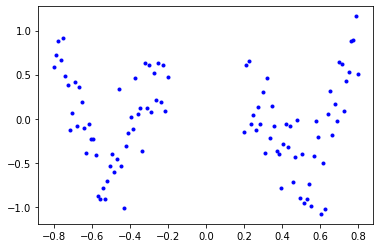

In [ ]:
def true_function(x):
    return x * jnp.sin(3*jnp.pi*x)
    
key = jax.random.PRNGKey(42)
num_train = 100
obs_std = 0.3
train_x = jnp.concatenate([jnp.linspace(-0.8, -0.2, num_train//2), jnp.linspace(0.2, 0.8, num_train//2)])
key, key_ = jax.random.split(key, 2)
train_y = true_function(train_x) + obs_std * jax.random.normal(key_, [num_train])
plt.plot(train_x, train_y, '.b')

One thing you should notice in the above code is that we are explicitly keeping track of the random seed ($\texttt{key}$) for random number generation. This is one property of $\texttt{jax}$ different from $\texttt{numpy}$, and helps us to enhance reproducibility. Whenever you want to generate something randomly, you should provide a $\texttt{key}$ for that.

Now we proceed to define a neural network architecture for our regression problem. We use a simple multi-layer perceptron (MLP) having two hidden layers. The codes below define the function to do forward pass through MLP and the function to initialize the parameters of MLP. The MLP takes an input $x$ and outputs the predicted function value $\mu(x;\theta)$ and its observation noise $\sigma(x;\theta)$ where $\theta$ is the parameter of the MLP.

Parameters of MLP are represented by a dictionary $\texttt{string} \to \texttt{jnp.ndarray}$.  $\texttt{W1}$ and $\texttt{b1}$ represent the weight matrix and bias vector of the first layer, and the rest should be clear. Note also how the code is using keys for random initialization.

In [ ]:
def MLP(params, x):
    y = jax.nn.swish(jnp.dot(x[...,None], params['W1']) + params['b1'])
    y = jax.nn.swish(jnp.dot(y, params['W2']) + params['b2'])
    y = jnp.dot(y, params['W3']) + params['b3']
    y_mean = y[...,0]
    y_std = jax.nn.softplus(y[...,1])
    return y_mean, y_std

def init_params(key, num_hidden):
    W_init = jax.nn.initializers.kaiming_normal()
    b_init = jax.nn.initializers.zeros

    key, key_ = jax.random.split(key, 2)
    keys = jax.random.split(key_, 6)    
    W1 = W_init(keys[0], (1, num_hidden))
    b1 = b_init(keys[1], (num_hidden,))
    W2 = W_init(keys[2], (num_hidden, num_hidden))
    b2 = b_init(keys[3], (num_hidden,))
    W3 = W_init(keys[4], (num_hidden, 2))
    b3 = b_init(keys[5], (2,))

    return key, {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2, 'W3':W3, 'b3':b3}

Now we define the likelihood and prior for Bayesian inference. The likelihood is simply given as a Gaussian,

$$
p(y|x, \theta) = \mathcal{N}(y | \mu(x;\theta), \sigma^2(x;\theta)).
$$

For the prior, we assume i.i.d. zero-mean Gaussian prior.

$$
p(\theta) = \mathcal{N}(\theta ; 0, \mathrm{diag}(\lambda^2)),
$$

where $\lambda$ is a hyperparameter for prior standard deviation. Given a training set $(X, Y) = \{(x_i, y_i)\}_{i=1}^n$, the joint likelihood is then computed as

$$
\displaystyle
p(Y, \theta | X) = p(\theta)\prod_{i=1}^n p(y_i|x_i, \theta).
$$

As an illustraion, let us first solve the regression via Maximum a Posterior (MAP). We need to minimize the negative log joint likelihood,

$$
U(\theta) = -\log p(\theta) - \sum_{i=1}^n \log p(y_i|x_i, \theta),
$$
and the codes below defines the functions computing the negative log joint likelihood.

In [ ]:
# computes -log p(y|x, params) except for the constants not depending on the parameters.
def neg_log_likel(params, x, y):
    y_mean, y_std = MLP(params, x)
    nll = 0.5 * (y - y_mean)**2 / y_std**2 + jnp.log(y_std) 
    return nll.sum()

# computes -log p(params) except for the constants not depending on the parameters.
def neg_log_prior(params, prior_std):    
    def nlp(x):
        return jnp.sum(0.5 * x.reshape(-1)**2 / prior_std**2)
    return sum(jax.tree_leaves(jax.tree_map(nlp, params)))

# computes -log p(y, params | x) except for the constants not depending on the parameters.
def neg_log_joint(params, x, y, prior_std):
    return neg_log_likel(params, x, y) + neg_log_prior(params, prior_std)        

What we have to do now is to compute the gradient of the $U(\theta)$ with $\theta$ for gradient descent. Using $\texttt{jax}$, this can be done very easily.

In [ ]:
def loss_and_grad(params, x, y, prior_std):
    return jax.value_and_grad(neg_log_joint, argnums=0)(params, x, y, prior_std)

The function above simply transforms our objective function into another function computing the loss values ($U$) and its gradient w.r.t. the parameter $(\nabla_\theta U(\theta))$. 

Throughout this homework, we will use fixed values for the hyperparameters (number of hidden nodes in MLP and prior standard deviation).

In [ ]:
# hyperparameters
num_hidden = 32
prior_std = 1.0

The code below  defines a training step of MAP procedure. The function $\texttt{train_step}$ takes the current parameters and optimizer state, does gradient descent, and returns the updated parameters, optimizer state, and loss value. $\texttt{jit}$ stands for just-in-time compilation, which makes the computation much faster.

In [ ]:
opt = optax.adam(1e-3)
@jax.jit
def train_step(params, opt_state):
    loss, grads = loss_and_grad(params, train_x, train_y, prior_std)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

Given the training step function, the MAP estimation is simple as below. 

In [ ]:
key, params = init_params(key, num_hidden)
opt_state = opt.init(params)
num_steps = 5000
for t in range(1, num_steps+1):
    loss, params, opt_state = train_step(params, opt_state)
    if t % 500 == 0:
        print(f'step {t}, loss {loss:.4f}')

step 500, loss -30.3284
step 1000, loss -39.6044
step 1500, loss -43.5640
step 2000, loss -45.7703
step 2500, loss -46.8278
step 3000, loss -47.4226
step 3500, loss -48.1751
step 4000, loss -49.0678
step 4500, loss -49.5685
step 5000, loss -49.6863


The code below test the trained MLP on the interval $[-1.1, 1.1]$. The blue line shows the mean prediction $\mu(x)$, and the shaded area visualizes $\pm\sigma(x)$ and $\pm 2 \sigma(x)$ interval. As you can see, the MAP estimation fits the model quite well, but it fails to properly capture the uncertainty, especially in the region where training data are scarse.

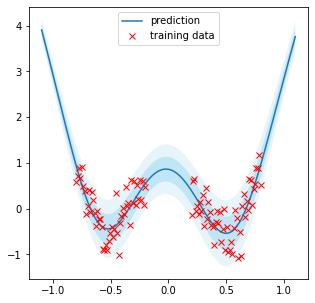

In [ ]:
test_x = jnp.linspace(-1.1, 1.1, 100)
y_mean, y_std = MLP(params, test_x)
plt.figure(figsize=(5, 5))
plt.fill_between(test_x, y_mean-2*y_std, y_mean+2*y_std, alpha=0.2, facecolor='skyblue', edgecolor=None)
plt.fill_between(test_x, y_mean-y_std, y_mean+y_std, alpha=0.4, facecolor='skyblue', edgecolor=None)
plt.plot(test_x, y_mean, label='prediction')
plt.plot(train_x, train_y, 'rx', label='training data')
plt.legend()

## Problem 1 (40pts)
In this problem, we will implement HMC for the given regression problem. Consider the Hamiltonian function defined as follows:

$$
H(\theta, p) = U(\theta) + K(p),
$$
where
$$
U(\theta) = -\sum_{i=1}^n \log p(y_i|x_i,\theta) - \log p(\theta), \quad 
K(p) = \frac{1}{2}p^\top p.
$$
That is, the potential energy is the negative log joint likelihood function defined above and the kinetic energy function is negative log density of standard Gaussian.

(a) (30pts) Fill the blank in the below code for a leapfrog step in HMC. Note that both parameters and momentums are represented as dictionaries; elementry operations such as addition or scalar multiplication may not be straightforward. You can use $\texttt{jax.tree_multimap}$ for this. For instance, say you have two dictionaries $\texttt{dict1}$ and $\texttt{dict2}$ having the same keys. You want to multiply $4.0$ to the values of the first dictionary, multiply $2.0$ to the values of the second dictionary and add them to make a new dictionary. This operation be implemented as follows:

$$
\texttt{result = jax.tree_multimap(lambda x1, x2: 4.0*x1 + 2.0*x2, dict1, dict2)}.
$$

For the first argument, you pass the function that you want to apply for each members of dictionaries. For the rest of the arguments, you pass the dictionaries that you will be applying the first argument. For more examples, see https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html.

In [ ]:
def generate_momentum(key, params):    
    momentum = {}
    for k, v in params.items():
        key, key_ = jax.random.split(key, 2)
        momentum[k] = jax.random.normal(key_, v.shape) 
    return key, momentum

@jax.jit
def HMC_step(key, params, eps, num_leapfrog_steps):   

    # Leapfrog step with step size eps.
    # takes the current (parameter, momentum, U, grads), do single leapfrog step,
    # and returns the updated (parameters, momentum, U, grads).
    def leapfrog_body(_, carry):
        params, momentum, U, grads = carry

        # fill this part
        ######################################################################
        momentum = jax.tree_multimap(
            lambda p, g: p - 0.5*eps*g,
            momentum, grads
        )
        params = jax.tree_multimap(
            lambda x, p: x + eps*p,
            params, momentum
        )
        U, grads = loss_and_grad(params, train_x, train_y, prior_std)        
        momentum = jax.tree_multimap(
            lambda p, g: p - 0.5*eps*g,
            momentum, grads
        )
        ######################################################################
        return (params, momentum, U, grads)

    # initialize momentum
    key, momentum = generate_momentum(key, params)
    U, grads = loss_and_grad(params, train_x, train_y, prior_std)
    K = sum([0.5*jnp.sum(p**2) for p in jax.tree_leaves(momentum)])
    H = U + K    

    # propose new sample via leapfrog integration
    new_params, new_momentum, new_U, new_grads = jax.lax.fori_loop(
        0, num_leapfrog_steps, leapfrog_body, (params, momentum, U, grads))
    new_K = sum([0.5*jnp.sum(p**2) for p in jax.tree_leaves(new_momentum)])
    new_H = new_U + new_K

    # compute acceptance probability   
    accept_prob = jnp.exp(jnp.minimum(0.0, -new_H + H))
    key, key_ = jax.random.split(key, 2)
    accepted = jax.random.uniform(key_) < accept_prob

    # MH accept-reject step
    (params, H, U, K) = jax.lax.cond(accepted, 
                                     lambda _: (new_params, new_H, new_U, new_K),
                                     lambda _: (params, H, U, K),
                                    operand=None)
    
    return key, accepted, params, H, U, K

Having completed the code above, we can run HMC using the following code.

In [ ]:
def HMC(key, eps, num_leapfrog_steps, num_steps, burn_in, thin):

    # initialize params
    key, params = init_params(key, num_hidden)
    samples = []
    num_accepted = 0
    for t in range(1, num_steps + 1):
        key, accepted, params, H, U, K = HMC_step(key, params, eps, num_leapfrog_steps)
        num_accepted += int(accepted)
        if t % 100 == 0:            
            nll = neg_log_likel(params, train_x, train_y)
            nlp = neg_log_prior(params, prior_std)
            print((
                f'step {t}, acc rate {num_accepted/t:.3f}, '
                f'H {H:.4f}, U {U:.4f}, K {K:.4f}, '
                f'nll {nll:.4f}, nlp {nlp:.4f}'
            ))

        if t > burn_in and t % thin == 0:
            samples.append(params)

    return samples

eps = 5e-4
num_leapfrog_steps = 100
num_steps = 3000
burn_in = 1500
thin = 10
samples = HMC(key, eps, num_leapfrog_steps, num_steps, burn_in, thin)

step 100, acc rate 1.000, H 745.6746, U 147.5237, K 598.1509, nll -45.3289, nlp 192.8526
step 200, acc rate 1.000, H 808.8175, U 213.1493, K 595.6682, nll -57.4081, nlp 270.5574
step 300, acc rate 1.000, H 870.0178, U 295.9455, K 574.0723, nll -58.5329, nlp 354.4784
step 400, acc rate 0.998, H 908.6749, U 334.6820, K 573.9929, nll -61.6002, nlp 396.2821
step 500, acc rate 0.996, H 970.5151, U 379.0479, K 591.4672, nll -63.5805, nlp 442.6285
step 600, acc rate 0.997, H 998.5116, U 414.1787, K 584.3329, nll -60.8115, nlp 474.9902
step 700, acc rate 0.997, H 1007.5538, U 436.8448, K 570.7090, nll -63.1078, nlp 499.9525
step 800, acc rate 0.996, H 1028.4119, U 449.1648, K 579.2471, nll -63.5312, nlp 512.6959
step 900, acc rate 0.997, H 1085.1465, U 473.3906, K 611.7560, nll -62.8806, nlp 536.2711
step 1000, acc rate 0.997, H 1080.8250, U 487.4088, K 593.4162, nll -56.5375, nlp 543.9463
step 1100, acc rate 0.997, H 1123.5137, U 513.2004, K 610.3133, nll -55.2573, nlp 568.4576
step 1200, acc

(b) (10pts) Having completed the code, run HMC to get samples. For visualization, we want to approximate the predictive means and variances for given test data. Complete the following code computing predictive means and variances using the samples collected from HMC. Hint: for variance, keep in mind the law of total variance.

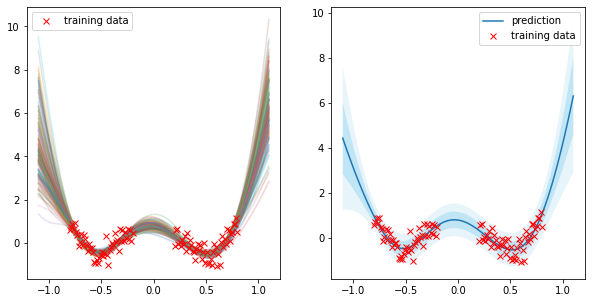

In [ ]:
def compute_pred_mean_and_std(means, stds):
     # complete this part
    ###################################################################
    pred_mean = means.mean(0)
    vars = stds**2
    pred_var = vars.mean(0) + means.var(0)
    pred_std = jnp.sqrt(pred_var)
    ###################################################################
    return pred_mean, pred_std

plt.figure(figsize=(10, 5))
plt.subplot(121)
test_x = jnp.linspace(-1.1, 1.1, 100)
y_means, y_stds = [], []
for params in samples:
    y_mean, y_std = MLP(params, test_x)
    plt.plot(test_x, y_mean, alpha=0.2)    
    y_means.append(y_mean)
    y_stds.append(y_std)
plt.plot(train_x, train_y, 'rx', label='training data')
plt.legend()

y_means = jnp.stack(y_means)
y_stds = jnp.stack(y_stds)
y_mean, y_std = compute_pred_mean_and_std(y_means, y_stds)
plt.subplot(122)
plt.fill_between(test_x, y_mean-2*y_std, y_mean+2*y_std, alpha=0.2, facecolor='skyblue', edgecolor=None)
plt.fill_between(test_x, y_mean-y_std, y_mean+y_std, alpha=0.4, facecolor='skyblue', edgecolor=None)
plt.plot(test_x, y_mean, label='prediction')
plt.plot(train_x, train_y, 'rx', label='training data')
plt.legend()

# Problem 2 (60pts)

Now we are going to solve the same regression problem using Bayes-by-Backprop (BBB). We assume the simplest possible mean-field Gaussian variational distribution for the parameters.

$$
q(\theta;\phi) = \mathcal{N}(\theta ; \mu_\phi, \mathrm{diag}(\sigma_\phi^2)).
$$

(a) (5pts) Complete the following code initializing the variationa parameters $\phi$. The code should look similar to $\texttt{init_params}$ function above, but now we have more parameters to initialize.

In [ ]:
def init_var_params(key, num_hidden):
    # sigma_uc is the unconstrained transform of sigma such that sigma = softplus(sigma_uc).    
    W_mu_init = jax.nn.initializers.kaiming_normal()
    W_sigma_uc_init = lambda key, shape: -3.0 + 0.1 * jax.random.normal(key, shape)
    b_mu_init = jax.nn.initializers.zeros
    b_sigma_uc_init = lambda key, shape: -3.0 + 0.1 * jax.random.normal(key, shape)

    # fill this part
    ################################################################################
    key, key_ = jax.random.split(key, 2)
    keys = jax.random.split(key_, 12)    
    W1_mu = W_mu_init(keys[0], (1, num_hidden))
    W1_sigma_uc = W_sigma_uc_init(keys[1], (1, num_hidden))
    b1_mu = b_mu_init(keys[2], (num_hidden,))
    b1_sigma_uc = b_sigma_uc_init(keys[3], (num_hidden,))

    W2_mu = W_mu_init(keys[4], (num_hidden, num_hidden))
    W2_sigma_uc = W_sigma_uc_init(keys[5], (num_hidden, num_hidden))
    b2_mu = b_mu_init(keys[6], (num_hidden,))
    b2_sigma_uc = b_sigma_uc_init(keys[7], (num_hidden,))

    W3_mu = W_mu_init(keys[8], (num_hidden, 2))
    W3_sigma_uc = W_sigma_uc_init(keys[9], (num_hidden, 2))
    b3_mu = b_mu_init(keys[10], (2,))
    b3_sigma_uc = b_sigma_uc_init(keys[11], (2,))
    ################################################################################

    var_params = {'W1_mu':W1_mu, 'W1_sigma_uc':W1_sigma_uc,
               'b1_mu':b1_mu, 'b1_sigma_uc':b1_sigma_uc, 
               'W2_mu':W2_mu, 'W2_sigma_uc':W2_sigma_uc,
               'b2_mu':b2_mu, 'b2_sigma_uc':b2_sigma_uc,
               'W3_mu':W3_mu, 'W3_sigma_uc':W3_sigma_uc,
               'b3_mu':b3_mu, 'b3_sigma_uc':b3_sigma_uc
               }
    return key, var_params

(b) (15pts) The objective function for the variational inference is the Evidence LOwer Bound (ELBO), which is computed as follows:

$$
\displaystyle
\mathcal{L}(\phi) = \sum_{i=1}^n \mathbb{E}_{q(\theta;\phi)}[\log p(y_i|x_i, \theta)] - \gamma\cdot D_\text{KL}[ q(\theta;\phi) \Vert p(\theta)].
$$

(Note that we are introducing additional scaling parameter $\gamma$ to control the strength of the KL-divergence term.) Since both $p(\theta)$ and $q(\theta;\phi)$ are Gaussians, we can compute their KL-divergence in close-form. Compute the KL divergence, and complete the following code to compute it.

In [ ]:
# compute KL divergence between q(mu, sigma) and p(0, prior_std)
def kl_divergence_(mu, sigma_uc, prior_std):
    # fill this part
    ################################################################################
    sigma = jax.nn.softplus(sigma_uc)
    return jnp.sum(jnp.log(prior_std/sigma) + 0.5*(sigma**2 + mu**2)/prior_std**2 - 0.5)
    ################################################################################

def kl_divergence(var_params, prior_std):
    kld = kl_divergence_(var_params['W1_mu'], var_params['W1_sigma_uc'], prior_std)
    kld += kl_divergence_(var_params['b1_mu'], var_params['b1_sigma_uc'], prior_std)
    kld += kl_divergence_(var_params['W2_mu'], var_params['W2_sigma_uc'], prior_std)
    kld += kl_divergence_(var_params['b2_mu'], var_params['b2_sigma_uc'], prior_std)
    kld += kl_divergence_(var_params['W3_mu'], var_params['W3_sigma_uc'], prior_std)
    kld += kl_divergence_(var_params['b3_mu'], var_params['b3_sigma_uc'], prior_std)
    return kld

(c) (30pts) The expected likelihood term is approximated with reparameterization trick. In this homework, we will implement the local reparameterization trick (https://arxiv.org/abs/1506.02557) that was covered in the class. Complete the code below doing forward passes with locally reparameterized samples from the variational distributions. You won't get any score if you implement the vanilla reparameterization trick.

In [ ]:
def MLP_local_reparam(key, var_params, x):

    # takes W_mu, W_sigma_uc, b_mu, b_sigma_uc and draw samples from
    # y ~ Wx + b where W ~ N(W_mu, W_sigma) and b ~ N(b_mu, b_sigma)
    def local_reparam_linear(key, W_mu, W_sigma_uc, b_mu, b_sigma_uc, x):
        # fill this part
        ################################################################################
        mean = jnp.dot(x, W_mu) + b_mu
        W_sigma = jax.nn.softplus(W_sigma_uc)
        b_sigma = jax.nn.softplus(b_sigma_uc)
        std = jnp.sqrt(jnp.dot(x**2, W_sigma**2) + b_sigma**2)
        key, key_ = jax.random.split(key, 2)
        eps = jax.random.normal(key_, mean.shape)
        output = mean + std * eps
        ################################################################################
        return key, output

    key, y = local_reparam_linear(
        key, var_params['W1_mu'], var_params['W1_sigma_uc'],
        var_params['b1_mu'], var_params['b1_sigma_uc'], x[...,None]
        )
    y = jax.nn.swish(y)
        
    key, y = local_reparam_linear(
        key, var_params['W2_mu'], var_params['W2_sigma_uc'],
        var_params['b2_mu'], var_params['b2_sigma_uc'], y
        )
    y = jax.nn.swish(y)

    key, y = local_reparam_linear(
        key, var_params['W3_mu'], var_params['W3_sigma_uc'],
        var_params['b3_mu'], var_params['b3_sigma_uc'], y
        )
    
    y_mean = y[...,0]
    y_std = jax.nn.softplus(y[...,1])
    return key, y_mean, y_std

(d) (10pts) Using the kl-divergence and local reparametrization implemented above, complete the code below computing the negative ELBO. Then run the remaining codes to verify your implementation.

In [ ]:
# computes negative ELBO,
# - E_q [log p(Y|X,theta)] + gamma * KL[q||p]
def neg_elbo(key, var_params, x, y, prior_std, gamma):
    # fill this part
    ################################################################################
    key, y_mean, y_std = MLP_local_reparam(key, var_params, x)
    nll = 0.5 * (y - y_mean)**2 / y_std**2 + jnp.log(y_std)
    kld = kl_divergence(var_params, prior_std)
    return nll.sum() + gamma * kld
    ################################################################################


def neg_elbo_and_grad(key, var_params, x, y, prior_std, gamma):
    grad_fn = jax.value_and_grad(neg_elbo, argnums=1)
    key, key_ = jax.random.split(key, 2)
    nelbo, grads = grad_fn(key, var_params, x, y, prior_std, gamma)
    return key, nelbo, grads

Run the code below to see if your implementation is right.

In [ ]:
opt = optax.adam(1e-3)
gamma = 0.1
@jax.jit
def bbb_train_step(key, var_params, opt_state):
    key, nelbo, grads = neg_elbo_and_grad(
        key, var_params, train_x, train_y, prior_std, gamma)
    updates, opt_state = opt.update(grads, opt_state)
    var_params = optax.apply_updates(var_params, updates)
    return key, nelbo, var_params, opt_state

In [ ]:
key, var_params = init_var_params(key, num_hidden)
opt_state = opt.init(var_params)
num_steps = 10000
for t in range(1, num_steps+1):
    key, nelbo, var_params, opt_state = bbb_train_step(key, var_params, opt_state)
    if t % 1000 == 0:
        print(f'step {t}, neg elbo {nelbo:.4f}')

step 1000, neg elbo 157.7012
step 2000, neg elbo 72.5883
step 3000, neg elbo 23.2862
step 4000, neg elbo -6.8778
step 5000, neg elbo -20.5895
step 6000, neg elbo -17.4238
step 7000, neg elbo -21.0294
step 8000, neg elbo -22.2285
step 9000, neg elbo -25.1686
step 10000, neg elbo -19.0857


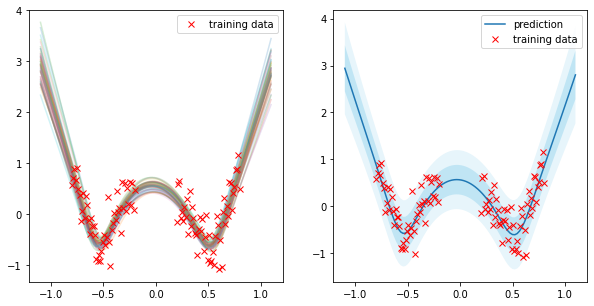

In [ ]:
# For evaluation, only one parameter is required for each test,
# so we use vanilla reparameterization trick.
def MLP_reparam(key, var_params, x):
    
    def reparam_linear(key, W_mu, W_sigma_uc, b_mu, b_sigma_uc, x):        
        W_sigma = jax.nn.softplus(W_sigma_uc)
        b_sigma = jax.nn.softplus(b_sigma_uc)

        key, key_ = jax.random.split(key, 2)
        eps = jax.random.normal(key_, W_sigma.shape)
        W = W_mu + W_sigma * eps

        key, key_ = jax.random.split(key, 2)
        eps = jax.random.normal(key_, b_sigma.shape)
        b = b_mu + b_sigma * eps

        return key, jnp.dot(x, W) + b

    key, y = reparam_linear(
        key, var_params['W1_mu'], var_params['W1_sigma_uc'],
        var_params['b1_mu'], var_params['b1_sigma_uc'], x[...,None]
        )
    y = jax.nn.swish(y)
        
    key, y = reparam_linear(
        key, var_params['W2_mu'], var_params['W2_sigma_uc'],
        var_params['b2_mu'], var_params['b2_sigma_uc'], y
        )
    y = jax.nn.swish(y)

    key, y = reparam_linear(
        key, var_params['W3_mu'], var_params['W3_sigma_uc'],
        var_params['b3_mu'], var_params['b3_sigma_uc'], y
        )
    
    y_mean = y[...,0]
    y_std = jax.nn.softplus(y[...,1])
    return key, y_mean, y_std

plt.figure(figsize=(10, 5))
plt.subplot(121)
test_x = jnp.linspace(-1.1, 1.1, 100)
y_means, y_stds = [], []
num_samples = 50
for i in range(num_samples):
    key, y_mean, y_std = MLP_reparam(key, var_params, test_x)
    plt.plot(test_x, y_mean, alpha=0.2)
    y_means.append(y_mean)    
    y_stds.append(y_std)
plt.plot(train_x, train_y, 'rx', label='training data')
plt.legend()

y_means = jnp.stack(y_means)
y_stds = jnp.stack(y_stds)
y_mean, y_std = compute_pred_mean_and_std(y_means, y_stds)
plt.subplot(122)
plt.fill_between(test_x, y_mean-2*y_std, y_mean+2*y_std, alpha=0.2, facecolor='skyblue', edgecolor=None)
plt.fill_between(test_x, y_mean-y_std, y_mean+y_std, alpha=0.4, facecolor='skyblue', edgecolor=None)
plt.plot(test_x, y_mean, label='prediction')
plt.plot(train_x, train_y, 'rx', label='training data')
plt.legend()